In [1]:
import os, tqdm, random, torch
import numpy as np
import torch.nn as nn
from PIL import Image
from multiprocessing import Manager as SharedMemoryManager
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet, BasicBlock
from typing import Optional, Union, Iterable, Tuple

#torch.autograd.set_detect_anomaly(True)

In [2]:
# Config Parameters
data_dir = '/kaggle/input/highresolution-anime-face-dataset-512x512/portraits'
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_channels = 3
first_fmap_channels = 64
last_fmap_channels = 512 #2048
output_channels = 3
time_embedding = 256
learning_rate = 1e-4 #1e-2
min_lr = 1e-6
weight_decay = 0.0
n_timesteps = 500
beta_min = 1e-4
beta_max = 2e-2
beta_scheduler = 'linear'
batch_size = 10
n_samples = 12_000
cache_size = 12_000
image_size = (64, 64)

number of images: 302652


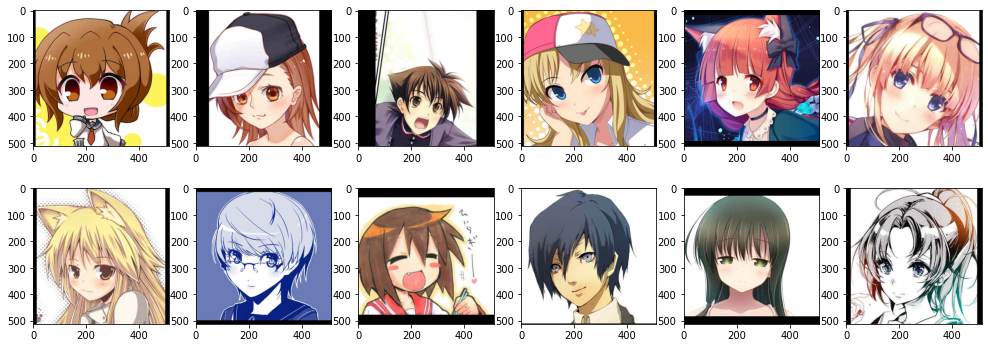

In [3]:
#load samples
files = os.listdir(data_dir)

print(f'number of images: {len(files)}')

n_rows, n_cols = 2, 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(17, 6))

for i in range(n_rows):
    for j in range(n_cols):
        idx = random.randint(0, len(files))
        img = Image.open(os.path.join(data_dir, f'{files[idx]}'))
        axs[i, j].imshow(img)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, img_dir:str, image_size:tuple, n_samples:int=4000, cache_size:int=1000):
        self.img_dir = img_dir
        self.n_samples = n_samples
        self.image_size = image_size
        self.cache_size = cache_size
        
        self.files = os.listdir(self.img_dir)
        self.files = random.sample(self.files, self.n_samples)
        
        r"""
        container for caching samples:
        structure
        ----------------------
        {idx:<image>}
        """
        self.cache = SharedMemoryManager().dict()
        
        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size), 
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        
    def __len__(self):
        return len(self.files)
    
    
    def _addToCache(self, idx:int, image:torch.Tensor):
        if self.cache_size > 0:
            if len(self.cache) >= self.cache_size:
                keys = list(self.cache.keys())
                key_to_remove = random.choice(keys)
                self.cache.pop(key_to_remove)
            self.cache[idx] = image
                
    
    def __getitem__(self, idx:int):
        if idx in self.cache.keys():return self.cache[idx]
        
        file_path = os.path.join(self.img_dir, self.files[idx])
        image = Image.open(file_path)
        
        if self.transforms:
            #apply transforms
            image = self.transforms(image)
            
        self._addToCache(idx, image)
            
        return image
        

shape: torch.Size([3, 64, 64])
min pixel value: -1.0
mean pixel value: -0.06596837192773819
max pixel value: 1.0


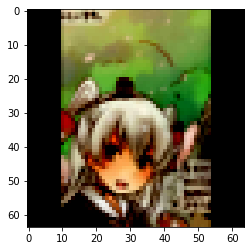

In [5]:
dataset = ImageDataset(data_dir, image_size, n_samples)
sample_img = dataset[0]

print(f'shape: {sample_img.shape}')
print(f'min pixel value: {sample_img.min()}')
print(f'mean pixel value: {sample_img.mean()}')
print(f'max pixel value: {sample_img.max()}')

plt.imshow(sample_img.permute(1, 2, 0))

In [6]:
class DiffusionUtils:
    def __init__(self, n_timesteps:int, beta_min:float, beta_max:float, device:str='cpu', scheduler:str='linear'):
        assert scheduler in ['linear', 'cosine'], 'scheduler must be linear or cosine'

        self.n_timesteps = n_timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.device = device
        self.scheduler = scheduler
        
        self.betas = self.betaSamples()
        self.alphas = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
    
    
    def betaSamples(self):
        if self.scheduler == 'linear':
            return torch.linspace(start=self.beta_min, end=self.beta_max, steps=self.n_timesteps).to(self.device)

        elif self.scheduler == 'cosine':
            betas = []
            for i in reversed(range(self.n_timesteps)):
                T = self.n_timesteps - 1
                beta = self.beta_min + 0.5*(self.beta_max - self.beta_min) * (1 + np.cos((i/T) * np.pi))
                betas.append(beta)
                
            return torch.Tensor(betas).to(self.device)
    
    
    def sampleTimestep(self, size:int):
        #the size argument will let you randomly sample a batch of timesteps
        #output shape: (N, )
        return torch.randint(low=1, high=self.n_timesteps, size=(size, )).to(self.device)
    
    
    def noiseImage(self, x:torch.Tensor, t:torch.LongTensor):
        #expected input is a batch of inputs.
        #image shape: (N, C, H, W)
        #t:torch.Tensor shape: (N, )
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        alpha_hat_sqrts = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        one_mins_alpha_hat_sqrt = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x).to(self.device)
        return (alpha_hat_sqrts * x) + (one_mins_alpha_hat_sqrt * noise), noise
    
    
    def sample(self, x:torch.Tensor, model:nn.Module):
        #x shape: (N, C, H, W)
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        model.eval()
        
        with torch.no_grad():
            iterations = range(1, self.n_timesteps)
            for i in tqdm.tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x.shape[0]) * i).long().to(self.device)
                
                #params
                alpha = self.alphas[t][:, None, None, None]
                beta = self.betas[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat
                
                #predict noise pertaining for a given timestep
                predicted_noise = model(x, t)
                
                if i > 1:noise = torch.randn_like(x).to(self.device)
                else:noise = torch.zeros_like(x).to(self.device)
                
                x = 1/torch.sqrt(alpha) * (x - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x = x + (torch.sqrt(beta) * noise)
                
            return x

linear beta scheduling...


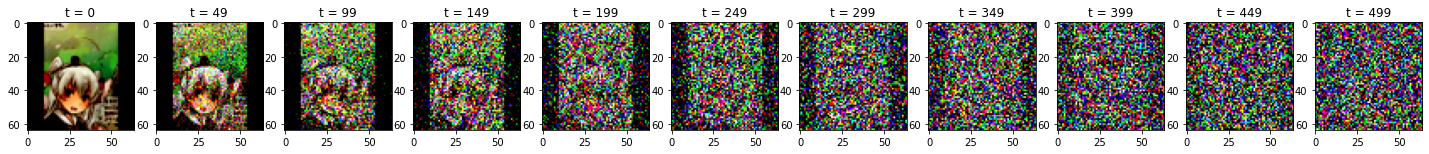



cosine beta scheduling...


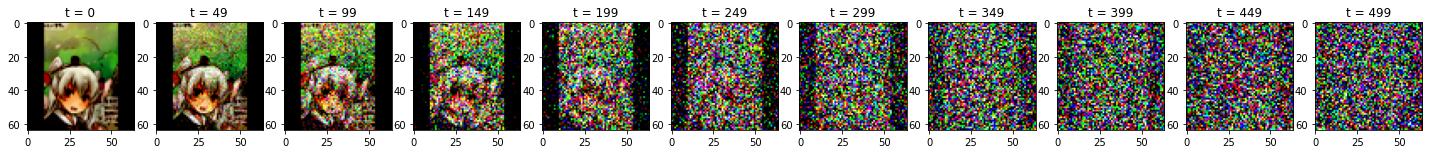

In [7]:
T = n_timesteps
n_steps = 50
alpha_values = {}

for scheduler in ['linear', 'cosine']:
    print(f'{scheduler} beta scheduling...')

    diffusion = DiffusionUtils(T, beta_min, beta_max, scheduler=scheduler)
    alpha_values[scheduler] = diffusion.alphas

    fig, axs = plt.subplots(1, (T//n_steps)+1, figsize=(25, 15))

    axs[0].imshow(sample_img.permute(1, 2, 0))
    axs[0].set_title('t = 0')

    for idx, t in enumerate(range(n_steps-1, T, n_steps)):
        t = torch.Tensor([t]).long()
        x, _ = diffusion.noiseImage(sample_img.unsqueeze(0), t)
        axs[idx+1].imshow(x.squeeze(0).permute(1, 2, 0))
        axs[idx+1].set_title(f't = {t.item()}')
    plt.show()
    print('\n')

Text(0.5, 1.0, 'alpha values of cosine scheduling')

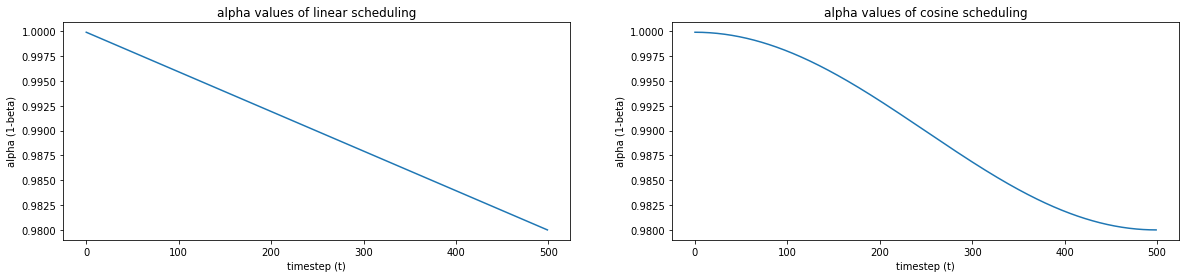

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(alpha_values['linear'])
axs[0].set_xlabel('timestep (t)')
axs[0].set_ylabel('alpha (1-beta)')
axs[0].set_title('alpha values of linear scheduling')

axs[1].plot(alpha_values['cosine'])
axs[1].set_xlabel('timestep (t)')
axs[1].set_ylabel('alpha (1-beta)')
axs[1].set_title('alpha values of cosine scheduling')

In [9]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim_size, n:int=10000):
        assert dim_size % 2 == 0, 'dim_size should be an even number'
            
        super(SinusoidalEmbedding, self).__init__()
        
        self.dim_size = dim_size
        self.n = n
        
    def forward(self, x:torch.Tensor):
        N = len(x)
        output = torch.zeros(size=(N, self.dim_size)).to(x.device)
        
        for idx in range(0, N):
            for i in range(0, self.dim_size//2):
                emb = x[idx] / (self.n ** (2*i / self.dim_size))
                output[idx, 2*i] = torch.sin(emb)
                output[idx, (2*i) + 1] = torch.cos(emb)
        
        return output

In [10]:
class ImageSelfAttention(nn.Module):
    def __init__(self, input_channels:int, n_heads:int):
        super(ImageSelfAttention, self).__init__()
        
        self.input_channels = input_channels
        self.n_heads = n_heads
        self.layernorm = nn.LayerNorm(self.input_channels)
        self.attention = nn.MultiheadAttention(self.input_channels, self.n_heads, batch_first=True)
        
    def forward(self, x:torch.Tensor):
        # shape of x: (N, C, H, W)
        _, C, H, W = x.shape
        x = x.reshape(-1, C, H*W).permute(0, 2, 1)
        normalised_x = self.layernorm(x)
        attn_val, _ = self.attention(normalised_x, normalised_x, normalised_x)
        attn_val = attn_val + x
        attn_val = attn_val.permute(0, 2, 1).reshape(-1, C, H, W)
        return attn_val

In [11]:
class Encoder(ResNet):
    def __init__(
        self, input_channels:int, time_embedding:int, 
        block=BasicBlock, block_layers:list=[2, 2, 2, 2], n_heads:int=4):
      
        self.block = block
        self.block_layers = block_layers
        self.time_embedding = time_embedding
        self.input_channels = input_channels
        self.n_heads = n_heads
        
        super(Encoder, self).__init__(self.block, self.block_layers)
        
        #time embedding layer
        self.sinusiodal_embedding = SinusoidalEmbedding(self.time_embedding)
        
        fmap_channels = [64, 64, 128, 256, 512]
        #layers to project time embeddings unto feature maps
        self.time_projection_layers = self.make_time_projections(fmap_channels)
        #attention layers for each feature map
        self.attention_layers = self.make_attention_layers(fmap_channels)
        
        self.conv1 = nn.Conv2d(
            self.input_channels, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False)
        
        self.conv2 = nn.Conv2d(
            64, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3),
            bias=False)

        #delete unwanted layers
        del self.maxpool, self.fc, self.avgpool
        
        
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        #embed time positions
        t = self.sinusiodal_embedding(t)
        
        #prepare fmap2
        fmap1 = self.conv1(x)
        t_emb = self.time_projection_layers[0](t)
        fmap1 = fmap1 + t_emb[:, :, None, None]
        fmap1 = self.attention_layers[0](fmap1)
        
        x = self.conv2(fmap1)
        x = self.bn1(x)
        x = self.relu(x)
        
        #prepare fmap2
        fmap2 = self.layer1(x)
        t_emb = self.time_projection_layers[1](t)
        fmap2 = fmap2 + t_emb[:, :, None, None]
        fmap2 = self.attention_layers[1](fmap2)
        
        #prepare fmap3
        fmap3 = self.layer2(fmap2)
        t_emb = self.time_projection_layers[2](t)
        fmap3 = fmap3 + t_emb[:, :, None, None]
        fmap3 = self.attention_layers[2](fmap3)
        
        #prepare fmap4
        fmap4 = self.layer3(fmap3)
        t_emb = self.time_projection_layers[3](t)
        fmap4 = fmap4 + t_emb[:, :, None, None]
        fmap4 = self.attention_layers[3](fmap4)
        
        #prepare fmap4
        fmap5 = self.layer4(fmap4)
        t_emb = self.time_projection_layers[4](t)
        fmap5 = fmap5 + t_emb[:, :, None, None]
        fmap5 = self.attention_layers[4](fmap5)
        
        return fmap1, fmap2, fmap3, fmap4, fmap5
    
    
    def make_time_projections(self, fmap_channels:Iterable[int]):
        layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding, ch)
            ) for ch in fmap_channels ])
        
        return layers
    
    def make_attention_layers(self, fmap_channels:Iterable[int]):
        layers = nn.ModuleList([
            ImageSelfAttention(ch, self.n_heads) for ch in fmap_channels
        ])
        
        return layers

In [12]:
class DecoderBlock(nn.Module):
    def __init__(
        self, input_channels:int, output_channels:int, 
        time_embedding:int, upsample_scale:int=2, activation:nn.Module=nn.ReLU,
        compute_attn:bool=True, n_heads:int=4):
        super(DecoderBlock, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.upsample_scale = upsample_scale
        self.time_embedding = time_embedding
        self.compute_attn = compute_attn
        self.n_heads = n_heads
        
        #attention layer
        if self.compute_attn:
            self.attention = ImageSelfAttention(self.output_channels, self.n_heads)
        else:self.attention = nn.Identity()
        
        #time embedding layer
        self.sinusiodal_embedding = SinusoidalEmbedding(self.time_embedding)
        
        #time embedding projection layer
        self.time_projection_layer = nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding, self.output_channels)
            )

        self.transpose = nn.ConvTranspose2d(
            self.input_channels, self.input_channels, 
            kernel_size=self.upsample_scale, stride=self.upsample_scale)
        
        self.instance_norm1 = nn.InstanceNorm2d(self.transpose.in_channels)

        self.conv = nn.Conv2d(
            self.transpose.out_channels, self.output_channels, kernel_size=3, stride=1, padding=1)
        
        self.instance_norm2 = nn.InstanceNorm2d(self.conv.out_channels)
        
        self.activation = activation()

    
    def forward(self, fmap:torch.Tensor, prev_fmap:Optional[torch.Tensor]=None, t:Optional[torch.Tensor]=None):
        output = self.transpose(fmap)
        output = self.instance_norm1(output)
        output = self.conv(output)
        output = self.instance_norm2(output)
        
        #apply residual connection with previous feature map
        if torch.is_tensor(prev_fmap):
            assert (prev_fmap.shape == output.shape), 'feature maps must be of same shape'
            output = output + prev_fmap
            
        #apply timestep embedding
        if torch.is_tensor(t):
            t = self.sinusiodal_embedding(t)
            t_emb = self.time_projection_layer(t)
            output = output + t_emb[:, :, None, None]
            
            output = self.attention(output)
            
        output = self.activation(output)
        return output

In [13]:
class Decoder(nn.Module):
    def __init__(
        self, last_fmap_channels:int, output_channels:int, 
        time_embedding:int, first_fmap_channels:int=64, n_heads:int=4):
        super(Decoder, self).__init__()
        
        self.last_fmap_channels = last_fmap_channels
        self.output_channels = output_channels
        self.time_embedding = time_embedding
        self.first_fmap_channels = first_fmap_channels
        self.n_heads = n_heads

        self.residual_layers = self.make_layers()

        self.final_layer = DecoderBlock(
            self.residual_layers[-1].input_channels, self.output_channels,
            time_embedding=self.time_embedding, activation=nn.Identity, 
            compute_attn=False, n_heads=self.n_heads)

        #set final layer second instance norm to identity
        self.final_layer.instance_norm2 = nn.Identity()


    def forward(self, *fmaps, t:Optional[torch.Tensor]=None):
        #fmaps(reversed): fmap5, fmap4, fmap3, fmap2, fmap1
        fmaps = [fmap for fmap in reversed(fmaps)]
        ouptut = None
        for idx, m in enumerate(self.residual_layers):
            if idx == 0:
                output = m(fmaps[idx], fmaps[idx+1], t)
                continue
            output = m(output, fmaps[idx+1], t)
        
        # no previous fmap is passed to the final decoder block
        # and no attention is computed
        output = self.final_layer(output)
        return output

      
    def make_layers(self, n:int=4):
        layers = []
        for i in range(n):
            if i == 0: in_ch = self.last_fmap_channels
            else: in_ch = layers[i-1].output_channels

            out_ch = in_ch // 2 if i != (n-1) else self.first_fmap_channels
            layer = DecoderBlock(
                in_ch, out_ch, 
                time_embedding=self.time_embedding,
                compute_attn=True, n_heads=self.n_heads)
            
            layers.append(layer)

        layers = nn.ModuleList(layers)
        return layers

In [14]:
class DiffusionNet(nn.Module):
    def __init__(self, encoder:Encoder, decoder:Decoder):
        
        super(DiffusionNet, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x:torch.Tensor, t:torch.Tensor):
        enc_fmaps = self.encoder(x, t=t)
        segmentation_mask = self.decoder(*enc_fmaps, t=t)
        return segmentation_mask

In [15]:
class TrainingPipeline:
    def __init__(self, model, lossfunc, optimizer, diffusion_utils:DiffusionUtils, 
                 device='cpu', weight_init=True, custom_weight_initializer=None):
        
        self.device = device
        self.model = model.to(self.device)
        self.lossfunc = lossfunc
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.diffusion_utils = diffusion_utils
        self.custom_weight_initializer = custom_weight_initializer
        
        if self.weight_init:
            if self.custom_weight_initializer:
                self.model.apply(self.custom_weight_initializer)
            else:
                self.model.apply(self.xavier_init_weights)
        
    
    def xavier_init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if torch.is_tensor(m.bias):
                m.bias.data.fill_(0.01)
    
    
    def save_model(self, dirname='./model_params', 
                   filename='DDPM.pth.tar'):
        if not os.path.isdir(dirname):os.mkdir(dirname)
        state_dicts = {
            'network_params':self.model.state_dict(),
            'optimizer_params':self.optimizer.state_dict(),
        }
        return torch.save(state_dicts, os.path.join(dirname, filename))
        

    def train(self, dataloader, verbose=False):
        self.model.train()
        loss = 0
        for idx, images in tqdm.tqdm(enumerate(dataloader)):
            self.model.zero_grad()
            #move images to device
            images = images.to(self.device)
            
            #sample timesteps from timestep sampler
            t = self.diffusion_utils.sampleTimestep(size=images.shape[0])
            
            #apply noise at given timesteps t to to the batch of images
            x_t, noise = self.diffusion_utils.noiseImage(images, t)
            
            #predict noise in noisy image (x_t) for the given timestep
            pred_noise = self.model(x_t, t)

            #compute batch loss
            batch_loss = self.lossfunc(pred_noise, noise)
            
            #backward propagation and optimization
            batch_loss.backward()
            self.optimizer.step()
            loss += batch_loss.item()
            
        loss = loss / (idx + 1)
        if verbose:
            print(f'Training Loss: {loss}')

        return loss

# Model Training and Testing

Now, its time to train the model. Firstly the dataset and dataloader objects are instantiated in the cell below.

In [16]:
#train dataset and dataloader
train_dataset = ImageDataset(data_dir, image_size, n_samples, cache_size)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Next, we seed our RNG (Random Number Generation) processes, for the sake of reproducability

In [17]:
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [18]:
#encoder, decoder model initialisation
encoder = Encoder(input_channels, time_embedding, block_layers=[2, 2, 2, 2])
decoder = Decoder(last_fmap_channels, output_channels, time_embedding, first_fmap_channels)
model = DiffusionNet(encoder, decoder)

#diffusion utilities class initialisaion
diffusion_utils = DiffusionUtils(n_timesteps, beta_min, beta_max, device, scheduler=beta_scheduler)

#loss function, optimizer and pipeline initialisation
lossfunc = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
pipeline = TrainingPipeline(model, lossfunc, optimizer, diffusion_utils, device, weight_init=True)

# load pretrained weights if available
checkpoint_path = '/kaggle/input/ddpm-model-params/model_params/DDPM.pth.tar'
if os.path.isfile(checkpoint_path):
    checkpoint_state = torch.load(checkpoint_path, map_location=device)['network_params']
    pipeline.model.load_state_dict(checkpoint_state)

#learning rate scheduler initialisation
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    pipeline.optimizer, T_max=epochs, eta_min=min_lr, verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-04.


In the cell below, the model is fed with random input just for the sake of testing, to see if the model has been defined correctly.

In [19]:
#test model output correctness
test_input = torch.randn(2, 3, *image_size).to(device)
t_test = torch.Tensor([2, 5]).to(device)
test = pipeline.model(test_input, t_test)
test.shape

torch.Size([2, 3, 64, 64])

Next the number of trainable parameters of the neural network model is counted in the cell below.

In [20]:
#num params
sum([i.numel() for i in pipeline.model.parameters()])

16548870

training cycle.



epoch: 0


1200it [40:47,  2.04s/it]



training loss: 0.04418945841840469
model saved at epoch 0


epoch: 1


1200it [38:47,  1.94s/it]


training loss: 0.044381235720744976


epoch: 2



1200it [38:20,  1.92s/it]


training loss: 0.0447009652996591


epoch: 3



1200it [38:42,  1.94s/it]



training loss: 0.043946102867291
model saved at epoch 3


epoch: 4


1200it [38:10,  1.91s/it]



training loss: 0.04399880323947097
generating samples...


499it [02:59,  2.79it/s]


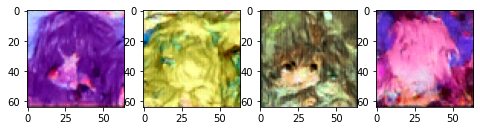

In [21]:
if torch.cuda.is_available():
    print(f'Model is training on {torch.cuda.get_device_name()} \n\n')

train_losses = []

best_loss = np.inf
for epoch in range(epochs):
    # train model
    print(f'\n\nepoch: {epoch}')
    train_loss = pipeline.train(train_dataloader)
    train_losses.append(train_loss)
    print(f'\ntraining loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        pipeline.save_model()
        print(f'model saved at epoch {epoch}')
        
    # generate samples every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == (epochs - 1):
        print('generating samples...')
        n = 4
        x = torch.randn(n, 3, *image_size).to(device)
        generated_images = diffusion_utils.sample(x, pipeline.model)
        generated_images = generated_images.cpu()
        #normalize to within range (0, 1) from range (-1, 1)
        generated_images = (generated_images.clamp(-1, 1) + 1) / 2

        fig, axs = plt.subplots(1, n, figsize=(8, 3))
        
        for i in range(n):
            img = generated_images[i].permute(1, 2, 0).numpy() * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
        plt.show()
    
    # decay learning rate
    # lr_scheduler.step()

Model is then initalised with best weight achieved during training, and is used to generate samples below.

In [22]:
best_model_path = os.path.join('./model_params', 'DDPM.pth.tar')
best_model_state = torch.load(best_model_path)['network_params']

pipeline.model.load_state_dict(best_model_state)

<All keys matched successfully>

generating samples...


499it [02:57,  2.81it/s]


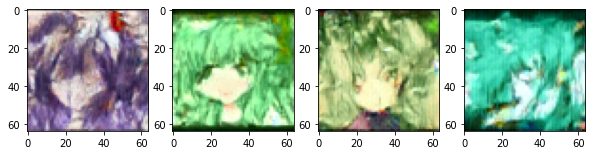

In [23]:
print('generating samples...')
n = 4

x = torch.randn(n, 3, *image_size).to(device)
generated_images = diffusion_utils.sample(x, pipeline.model)
generated_images = generated_images.cpu()
#normalize to within range (0, 1) from range (-1, 1)
generated_images = (generated_images.clamp(-1, 1) + 1) / 2

fig, axs = plt.subplots(1, n, figsize=(10, 3))
for i in range(n):
    img = generated_images[i].permute(1, 2, 0) * 255
    img = img.type(torch.uint8)
    axs[i].imshow(img)
plt.show()